# KNN
Here we use K Nearest Neighbors algorithm to perform classification task

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from rdkit import Chem, DataStructs
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from tqdm.notebook import tqdm

## Load Dataset

In [63]:
# collect dataset
dataset = pd.read_pickle('../processed_data/combined_dataset.pkl')
dcm = pd.read_pickle('../processed_data/DarkChemicalMatter_processed.pkl.gz')

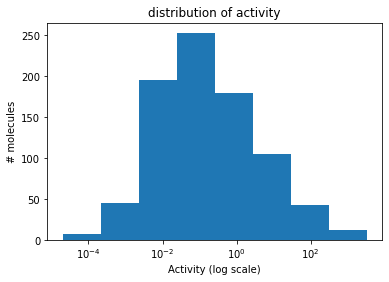

In [64]:
# visualize dataset
plt.figure()
hist, bins, _ = plt.hist(dataset.acvalue_target, bins=8)
plt.clf()
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
plt.hist(dataset.acvalue_target, bins=logbins, label=f"{len(dataset)} samples")
plt.xscale('log')
plt.xlabel('Activity (log scale)')
plt.ylabel('# molecules')
plt.title('distribution of activity')
plt.show()

# KNN Initializations

In [65]:
# define our tanimoto similarity function, to be used as distance metric in knn
# currently, using this distance metric makes our KNN do really poorly.
def tanimoto_similarity(fp1, fp2):
    """from http://infochim.u-strasbg.fr/CS3_2014/Slides/CS3_2014_Willett.pdf"""
    c = np.sum((fp1 == fp2) & (fp1 == 1))  # bits set in common
    a = np.sum(fp1)  # bits set in fp1
    b = np.sum(fp2)  # bits set in fp2
    if (a + b - c) == 0:
        print(a, b, c)
    return c / (a + b - c)

# Classification

## KNN Setup

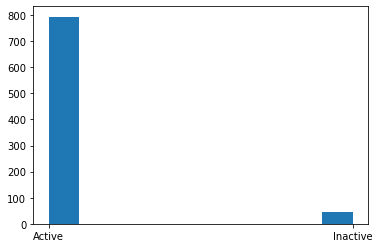

In [66]:
# set up features (X) and labels (y) for knn
X = np.stack(dataset.morgan_fingerprint)
y = dataset.activity_target.values
h = plt.hist(y)

X shape:(1588, 2048), y shape: (1588,)


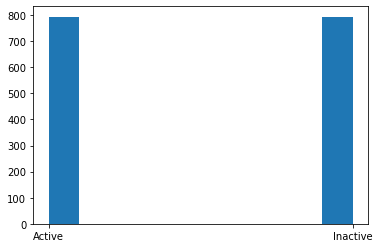

In [107]:
def augment_with_dcm(X, y, num_negatives):# augment the data with dcm examples
    dcm_X = np.stack(dcm.morgan_fingerprint)

    # select subset
    # current method: random choice.  There might be a better way.
    dcm_X = dcm_X[np.random.choice(np.arange(len(dcm_X)), size=num_negatives, replace=False)]
    dcm_y = np.array(['Inactive'] * len(dcm_X))

    # combine
    X = np.concatenate([X, dcm_X], axis=0)
    y = np.concatenate([y, dcm_y])
    return X, y
# how many negatives should we choose?  This is up for debate.  Current strategy: balance Active/Inactive
num_negatives = np.count_nonzero(y == 'Active') - np.count_nonzero(y == 'Inactive')
X, y = augment_with_dcm(X, y, num_negatives)
print(f'X shape:{X.shape}, y shape: {y.shape}')
h = plt.hist(y)

In [87]:
# set up data and labels for knn

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=3)
print(f"train_X.shape: {train_X.shape}")
print(f"train_y.shape: {train_y.shape}")
print(f"test_X.shape: {test_X.shape}")
print(f"test_y.shape: {test_y.shape}")

train_X.shape: (1111, 2048)
train_y.shape: (1111,)
test_X.shape: (477, 2048)
test_y.shape: (477,)


In [88]:
# define our knn function
def run_knn_classifier(k, train_X, train_y, test_X, test_y):
    nbrs = KNeighborsClassifier(n_neighbors=k, algorithm='auto', weights='distance')
    nbrs.fit(train_X, train_y)
    return nbrs.predict(test_X)

## Optimize KNN Classifier

In [89]:
def plot_knn_acc(k):
    pred_k2 = run_knn_classifier(k, train_X, train_y, test_X, test_y)
    plt.figure()
    plt.plot(test_y=='Active', label='truth')
    plt.plot(pred_k2=='Active', label='prediction')
    plt.xlabel('test molecule idx')
    plt.ylabel('')
    plt.legend()
    plt.title(f"k={k}")
    plt.show()

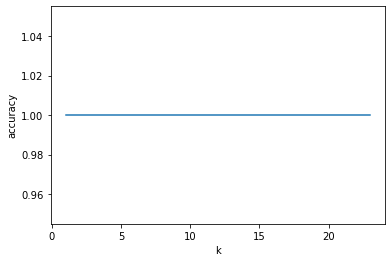

In [93]:
# show performance over various ks
def optimize_knn(train_X, train_y, test_X, test_y, max_k):
    accuracies = []
    ks = np.arange(1, max_k, 2)
    for k in tqdm(ks):
        pred = run_knn_classifier(k, train_X, train_y, test_X, test_y)
        accuracies.append(np.count_nonzero(pred == test_y) / len(test_y))
    plt.plot(ks, accuracies)
    plt.xlabel("k")
    plt.ylabel("accuracy")
    plt.show()
    return ks, accuracies

ks, accuracies = optimize_knn(train_X, train_y, test_X, test_y, max_k=25)

In [76]:
optimal_k = ks[np.argmax(accuracies)]

# Experiment: train on off-targets+dcm, test on TMPRSS2

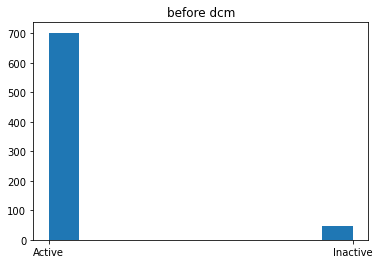

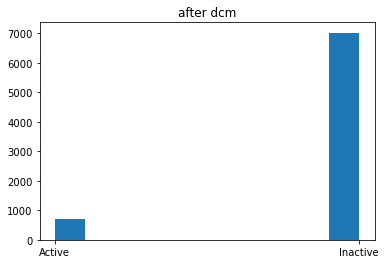

In [116]:
train = dataset[dataset.target!='TMPRSS2']
test = dataset[dataset.target=='TMPRSS2']

train_X = np.stack(train.morgan_fingerprint)
train_y = train.activity_target.values
plt.figure()
plt.hist(train_y)
plt.title('before dcm')

num_negatives = 10*np.count_nonzero(train_y == 'Active') - np.count_nonzero(train_y == 'Inactive')
train_X, train_y = augment_with_dcm(train_X, train_y, num_negatives)
plt.figure()
plt.hist(train_y)
plt.title('after dcm')

test_X = np.stack(test.morgan_fingerprint)
test_y = test.activity_target.values

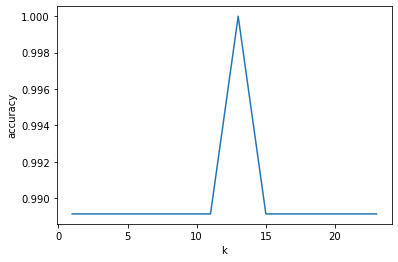

In [118]:
ks, accuracies = optimize_knn(train_X, train_y, test_X, test_y, max_k=25)

It appears we can do perfectly, even with a large amount of DCM added.  That's really encouraging.  I'm a bit skeptical, noting that many of the compounds in TMPRSS2 set have been assayed directly against the other molecules, so there is a distance of 0 in the KNN.  So, the KNN can say "hey, this compound was assayed against TMPRSS6 and came back Active, so let's say Active."  So it's unclear if it would perform as well if there wasn't such overlap.  That's another good experiment to do.

The other reason this could be non-legit is because our TMPRSS2 data is ALL active, and before adding DCM, the train set is also almost all active.  The DCM added could be occupying quite a different area in fingerprint space than our train/test sets, to the point that adding it to the training set has no impact.  Ideally, we should find a way to get DCMs which are most similar to our training data, rather than randomly selecting.

(array([ 0.,  0.,  0.,  0.,  0., 92.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

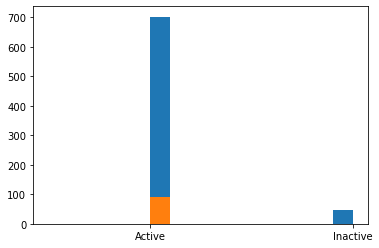